# Capstone 2 Pre-processing and Training<a id="Pre-processing_and_Training"></a>

## Table of Contents<a id='Table_of_Contents'></a>
* [3 Pre-processing and Training](#Pre-processing_and_Training)
    * [3.1 Imports](#Imports)
        * [3.1.1 Import Libraries](#Import_Libraries)
        * [3.1.2 Import Data](#Import_Data)          
    
    * [3.2 Feature_Engineering](#Feature_Engineering)
 
    * [3.3 Pre-processing](#Pre-processing)
    
    * [3.4 Model Selection](#Model_Selection)
        * [3.4.1 Train/Test Split](#Train_Test_Split)
        * [3.4.2 Dummy Classifier](#Dummy_Classifier)
        * [3.4.3 Linear Classifiers](#Linear_Classifiers)
            * [3.4.3.1 Logistic Regression](#Logistic_Regression)
            * [3.4.3.2 Support Vector Machines (SVM)](#SVM)
        * [3.4.4 Non-Linear Classifiers](#Non-Linear_Classifiers)
            * [3.4.4.1 Random Forest Classifier](#Random_Forest_Classifier)
            * [3.4.4.2 XG Boost](#XG_Boost)
            * [3.4.4.3 K Nearest Neighbors (KNN) Classifier](#KNN_Classifier)
            
    * [3.5 Hyperparemeter Tuning](#Hyperparameter_Tuning)
        * [3.5.1 Number of Estimators](#N_Estimators)
        * [3.5.2 Tree Parameters](#Tree_Parameters)
        * [3.5.3 Regularization Parameters](#Regularization_Parameters)
            
        
        

## 3.1 Imports<a id="Imports"></a>

### 3.1.1 Import Libraries<a id="Import_Libraries"></a>

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings 

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, plot_roc_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score, GridSearchCV

### 3.1.2 Import Data<a id="Import_Data"></a>

In [2]:
# Import dtypes
dtype_map = pd.read_csv("../data/processed/dtype_map.csv", index_col="index").to_dict()["0"]

# Import data
data = pd.read_csv("../data/processed/combined.csv")

# Transform the dtype of the data using the dtype_map
data = data.astype(dtype_map)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599990 entries, 0 to 599989
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   msno                    599990 non-null  object        
 1   transaction_date        599990 non-null  datetime64[ns]
 2   is_churn                599990 non-null  int64         
 3   payment_method_id       599990 non-null  object        
 4   payment_plan_days       599990 non-null  int64         
 5   plan_list_price         599990 non-null  int64         
 6   actual_amount_paid      599990 non-null  int64         
 7   is_auto_renew           599990 non-null  int64         
 8   membership_expire_date  599990 non-null  datetime64[ns]
 9   is_cancel               599990 non-null  int64         
 10  city                    599990 non-null  object        
 11  age                     599990 non-null  int64         
 12  gender                  599990

## 3.2 Feature Engineering<a id="Feature_Engineering"></a>

In [3]:
# Calculate seconds listened per day: secs_per_day
data["secs_per_day"] = data.total_secs / data.total_days

In [4]:
# Calculate each subscriber's cost per day: cost_per_day
data["cost_per_day"] = data.actual_amount_paid / data.payment_plan_days

In [5]:
# Calculate membership duration: mem_duration
data["mem_duration"] = data["membership_expire_date"] - data["registration_init_time"]

# Change data type to int64
data["mem_duration"] = data["mem_duration"].dt.days

In [6]:
# Get the total number of transactions each subscriber made: num_transactions
transactions_df = pd.read_csv("../data/raw/transactions_v2.csv")
num_trans = transactions_df.groupby("msno").msno.count()
num_trans_df = pd.DataFrame(num_trans).rename({"msno":"num_transactions"}, axis=1).reset_index()
data = pd.merge(data, num_trans_df, on="msno", how="inner")

In [7]:
data.head(1).T

,0
msno,++6xEqu4JANaRY4GjEfEFtLtqOvZvYPyP3uk/PW9Ces=
transaction_date,2017-03-31 00:00:00
is_churn,0
payment_method_id,41
payment_plan_days,30
plan_list_price,99
actual_amount_paid,99
is_auto_renew,1
membership_expire_date,2017-04-30 00:00:00
is_cancel,0


## 3.3 Pre-processing<a id="Pre-processing"></a>

In [8]:
# drop msno id column
data = data.drop("msno", axis=1)

# drop date columns
datetimes = data.select_dtypes(include="datetime64[ns]").columns.to_list()
data = data.drop(datetimes, axis=1)

In [9]:
# Set datatypes of boolean columns
bool_features = ["is_churn", "is_auto_renew", "is_cancel"]
data = data.astype({col:"bool" for col in bool_features})
data.dtypes

is_churn                 bool
payment_method_id      object
payment_plan_days       int64
plan_list_price         int64
actual_amount_paid      int64
is_auto_renew            bool
is_cancel                bool
city                   object
age                     int64
gender                 object
registered_via         object
total_days              int64
total_num_25            int64
total_num_50            int64
total_num_75            int64
total_num_985           int64
total_num_100           int64
total_num_unique        int64
total_secs            float64
secs_per_day          float64
cost_per_day          float64
mem_duration            int64
num_transactions        int64
dtype: object

In [10]:
# Define a column transformer to scale numerical features and encode categorical features: col_transform
num_features = data.select_dtypes(include=["int64", "float64"]).columns.to_list()
cat_features = data.select_dtypes(include="object").columns.to_list()
transformer = ColumnTransformer(transformers=[("num", StandardScaler(), num_features),
                                               ("cat", OneHotEncoder(), cat_features)])

## 3.4 Model Selection<a id="Model_Selection"></a>

### 3.4.1 Train/Test Split<a id="Train_Test_Split"></a>

In [11]:
# Separate independent and dependent variables
X = data.drop("is_churn", axis=1)
y = data.is_churn

In [12]:
# Split data using a 70/30 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

### 3.4.2 Dummy Classifier<a id="Dummy_Classifier"></a>

Here we will use a dummy classifer to get a baseline score for recall and ROC/AUC to compare against our results with genuine classifiers. 

In [13]:
# Instantiate a dummy classifer that uses the most frequent target value for all predictions
dummy_cls = DummyClassifier(strategy="most_frequent")
dummy_cls.fit(X_train, y_train)
dummy_pred = dummy_cls.predict(X_test)

In [14]:
# Get accuracy and recall from dummy classifer
dummy_accuracy = dummy_cls.score(dummy_pred, y_test)
dummy_recall = recall_score(y_test, dummy_pred)
print("The dummy classifier is {:.2f}% accurate".format(dummy_accuracy*100))
print("The recall for the dummy classifier is {}".format(dummy_recall))

The dummy classifier is 94.45% accurate
The recall for the dummy classifier is 0.0


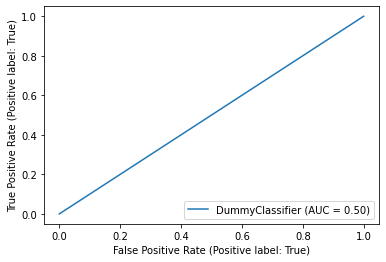

In [15]:
# Get ROC-AUC curve for dummy classifier
plot_roc_curve(dummy_cls, X_train, y_train);

We can see that accuracy would not be a good metric for determining model success, as a dummy classifier that just predicts that all users will renew is 94.45% accurate. Recall gives us a much more accurate idea of how good our model is, as it tells us how many users that churned are missed (false negatives). With the dummy classifier, every positive case was miss-classified as negative, so the recall score is 0. 

In the EDA stage, we plotted a scatterplot of the target value, is_churn, and concluded that a linear classifier would not be effective because there was a large section of positive and negative points that overlapped. Let's see if this is true by comparing the recall of linear classifiers with non-linear ones. 

### 3.4.3 Linear Classifiers<a id="Linear_Classifers"></a>

In [16]:
recall_scores = {}

#### 3.4.3.1 Logistic Regression<a id="Logisitic_Regression"></a>

In [17]:
# Create pipeline to transform features and apply classifier: logreg
logreg = Pipeline(steps=[("transformer", transformer), ("classifier", LogisticRegression(max_iter=400))])
logreg.fit(X_train, y_train)
log_pred = logreg.predict(X_test)
recall = recall_score(y_test, log_pred)
recall_scores["Logistic Regression"] = recall
recall

0.2990990990990991

#### 3.4.3.2 Support Vector Machines (SVM) <a id="SVM"></a>

In [35]:
warnings.filterwarnings("ignore")

# Pipeline to apply a support vector classifier: svc_cls
svc_cls = Pipeline(steps=[("transformer", transformer), ("classifier", LinearSVC(max_iter=2000))])
svc_cls.fit(X_train, y_train)
svc_pred = svc_cls.predict(X_test)
recall = recall_score(y_test, svc_pred)
recall_scores["SVC"] = recall
recall

/Users/Bradley/Desktop/springboard/capstone2/env/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


### 3.4.4 Non-Linear Classifiers<a id="Non-Linear_Classifers"></a>

#### 3.4.4.1 Random Forest Classifier <a id="Random_Forest_Classifier"></a>

In [19]:
# Pipeline to apply a random forest classifier: rf_cls
rf_cls = Pipeline(steps=[("transformer", transformer), ("classifier", RandomForestClassifier())])
rf_cls.fit(X_train, y_train)
rf_pred = rf_cls.predict(X_test)
recall = recall_score(y_test, rf_pred)
recall_scores["Random Forest"] = recall
recall

0.42802802802802803

#### 3.4.4.2 XG Boost<a id="XG_Boost"></a>

In [34]:
warnings.filterwarnings("ignore")

# Pipeline to apply an XG Boost classifier: xg_cls
xg_cls = Pipeline(steps=[("transformer", transformer), ("classifier", XGBClassifier(use_label_encoder=False))])
xg_cls.fit(X_train, y_train)
xg_pred = xg_cls.predict(X_test)
recall = recall_score(y_test, xg_pred)
recall_scores["XGBoost"] = recall
recall

[17:04:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.45465465465465466

#### 3.4.4.3 K Nearest Neighbors (KNN) Classifier <a id="KNN_Classifier"></a>

In [21]:
# Pipeline to apply an KNN classifier: knn_cls
knn_cls = Pipeline(steps=[("transformer", transformer), ("classifier", KNeighborsClassifier())])
knn_cls.fit(X_train, y_train)
knn_pred = knn_cls.predict(X_test)
recall = recall_score(y_test, knn_pred)
recall_scores["KNN"] = recall
recall

0.36956956956956954

In [32]:
pd.DataFrame.from_dict(recall_scores, orient="index", columns=["recall"]).sort_values(by="recall", ascending=False)

,recall
XGBoost,0.454655
Random Forest,0.428028
KNN,0.369570
Logistic Regression,0.299099
SVC,0.298799


As expected, we get the worst recall scores with the linear classifiers. 

Of the non-linear classifiers, XGBoost scores the best on recall. 

Now, let's adjust hyperparameters to try and get recall closer to 1. 

## 3.5 Hyperparameter Tuning<a id="Hyperparameter_Tuning"></a>

### 3.5.1 Number of Estimators<a id="N_Estimators"></a>

In [ ]:
model = XGBClassifier()
n_estimators = range(50,500,50)
param_grid = {"n_estimators":n_estimators}
grid_search = GridSearchCV(model, param_grid, scoring="recall", n_jobs=-1, cv=3)
results = grid_search.fit(transformer.fit_transform(X_train), y_train)
print("Best score:", results.best_score_)
print("Best number of estimators:", results.best_params_)

### 3.5.2 Tree Parameters<a id="Tree_Parameters"></a>

### 3.5.3 Regularization Parameters<a id="Regularization_Parameters"></a>

In [22]:
# Save data to file
#data.to_csv("../data/processed/pre_processing.csv", index=False)

In [23]:
# Save best model to pickle
#pickle.dump(best_model)